In [21]:
from tsl.data import SpatioTemporalDataset, SpatioTemporalDataModule
from tsl.data.preprocessing import StandardScaler
from MMD import mmd_rbf, mmd_linear, mmd_poly
from tsl.datasets import AirQuality, MetrLA, PemsBay
from GRGN.Engines.Generator import Generator
from GRGN.GRGNModel import GRGNModel
from GRGN.Loss.LogLikelihood import LogLikelihood
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tsl.utils.casting import torch_to_numpy
import matplotlib.pyplot as plt
import torch
from GRGN.Utils.reshapes import reshape_to_original


In [22]:
model = '/data/p.magos/TSGen/logs/generation/MetrLA/MetrLA-model-epoch=12-val_loss=3.6051.ckpt'

In [23]:
dataset = MetrLA()

adj = dataset.get_connectivity(**{'method': 'distance',
'threshold': 0.1,
'include_self': False,
'layout': 'edge_index'
})

# instantiate dataset
torch_dataset = SpatioTemporalDataset(target=dataset.dataframe()[-10000:],
                                    covariates=None,
                                    connectivity=adj,
                                    window=1,
                                    stride=1)
scalers = {'target': StandardScaler(axis=(0, 1))}

dm = SpatioTemporalDataModule(
    dataset=torch_dataset,
    scalers=scalers,
    splitter=dataset.get_splitter(**{'val_len': 0.2, 'test_len': 0.1}),
    batch_size=1,
    workers=32)
dm.setup(stage='test')

# if cfg.get('in_sample', False):
dm.trainset = list(range(len(torch_dataset)))

/data/p.magos/.pyenv/versions/3.11.9/lib/python3.11/site-packages/tsl/datasets/metr_la.py:96: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  date_range = pd.date_range(datetime_idx[0],
/data/p.magos/.pyenv/versions/3.11.9/lib/python3.11/site-packages/tsl/datasets/metr_la.py:109: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  df = df.replace(to_replace=0., method='ffill')


In [24]:
generator = Generator.load_from_checkpoint(model)
loss_fn = LogLikelihood(both=True)

TypeError: Generator.load_model() missing 1 required positional argument: 'self'

In [25]:
trainer = Trainer()

trainer.ckpt_path= model

generator.freeze()
# trainer.test(generator, datamodule=dm)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [26]:
output = trainer.predict(generator, dataloaders=dm.val_dataloader())
output = generator.collate_prediction_outputs(output)
output = torch_to_numpy(output)
y_hat, y_true = (output['y_hat'], output['y'])

Restoring states from the checkpoint path at /data/p.magos/TSGen/logs/generation/MetrLA/MetrLA-model-epoch=12-val_loss=3.6051.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at /data/p.magos/TSGen/logs/generation/MetrLA/MetrLA-model-epoch=12-val_loss=3.6051.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Only args ['edge_weight', 'edge_index', 'x'] are forwarded to the model (GRGNModel). 


In [27]:
res = dict(Loss=loss_fn.loss_function(torch.tensor(y_hat), torch.tensor(y_true)))
res

{'Loss': tensor([-4.2510])}

In [28]:
y_true = torch.tensor(y_true)
y_hat = torch.tensor(y_hat)

In [41]:
y_true.shape

input = y_true[-100:-99]
input = scalers['target'].transform(input)
input.shape

torch.Size([1, 1, 207, 1])

In [42]:
generation, out = generator.generate(input, torch.tensor(adj[0]), torch.Tensor(adj[1]), None, 'mean', 100)

In [43]:
generation = torch.cat(generation)

true = y_true.reshape(y_true.shape[0], y_true.shape[-2])
# true = scalers['target'].transform(true)[0]
generation = generation.reshape(generation.shape[0], generation.shape[-2])
generation = scalers['target'].inverse_transform(generation)[0]
generation.shape

torch.Size([100, 207])

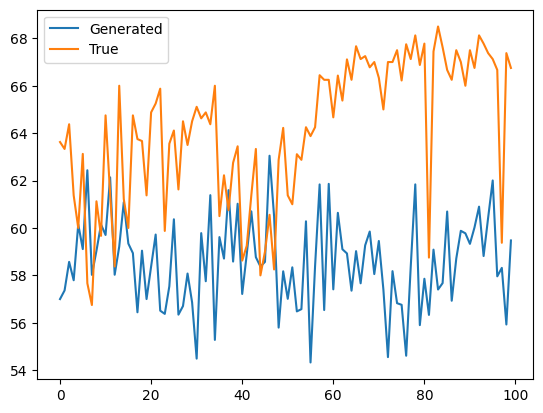

In [60]:
# plt.plot(generation[:, 10], label='Generated')
# plt.plot(true[-100:, 10], label='True')

plt.plot(generation[:, 10], label='Generated')
plt.plot(true[-100:, 10], label='True')
plt.legend()

In [45]:
X = true
Y = generation
X1 = scalers['target'].transform(X)[0]
Y1 = scalers['target'].transform(Y)[0]

In [46]:
MMD_RBF = mmd_rbf(torch.Tensor(X), torch.Tensor(Y))
MMD_LIN = mmd_linear(torch.Tensor(X), torch.Tensor(Y)).numpy()
MMD_POLY = mmd_poly(torch.Tensor(X), torch.Tensor(Y))

MMD_RBF_SCALED = mmd_rbf(torch.Tensor(X1), torch.Tensor(Y1))
MMD_LIN_SCALED = mmd_linear(torch.Tensor(X1), torch.Tensor(Y1)).numpy()
MMD_POLY_SCALED = mmd_poly(torch.Tensor(X1), torch.Tensor(Y1))

print('MMD_RBF: ', MMD_RBF)
print('MMD_LIN: ', MMD_LIN)
print('MMD_POLY: ', MMD_POLY)
print('MMD_RBF Scaled Data:', MMD_RBF_SCALED)
print('MMD_LIN Scaled Data:', MMD_LIN_SCALED)
print('MMD_POLY Scaled Data:', MMD_POLY_SCALED)

MMD_RBF:  0.011377764865756035
MMD_LIN:  10906.134
MMD_POLY:  14546894848.0
MMD_RBF Scaled Data: 0.011775077320635319
MMD_LIN Scaled Data: 60.62297
MMD_POLY Scaled Data: 9593.035044670105


In [53]:
y_true.shape

input = y_true[-200:-100]
input = scalers['target'].transform(input)
input.shape

torch.Size([100, 1, 207, 1])

In [54]:
prediction, out = generator.predict(input, torch.tensor(adj[0]), torch.Tensor(adj[1]), 'mean')
prediction.shape

torch.Size([100, 207])

In [55]:
true = y_true.reshape(y_true.shape[0], y_true.shape[-2])
# true = scalers['target'].transform(true)[0]
# prediction = prediction.reshape(prediction.shape[0], prediction.shape[-2])
prediction = scalers['target'].inverse_transform(prediction)[0]
prediction.shape

torch.Size([100, 207])

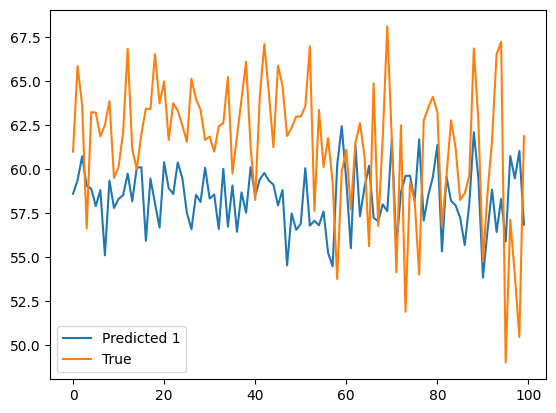

In [59]:
plt.plot(prediction[:, 1], label='Predicted 1')
plt.plot(true[-199:-99, 50], label='True')
plt.legend()

In [57]:
X = true
Y = generation
X1 = scalers['target'].transform(X)[0]
Y1 = scalers['target'].transform(Y)[0]

In [58]:
MMD_RBF = mmd_rbf(torch.Tensor(X), torch.Tensor(Y))
MMD_LIN = mmd_linear(torch.Tensor(X), torch.Tensor(Y)).numpy()
MMD_POLY = mmd_poly(torch.Tensor(X), torch.Tensor(Y))

MMD_RBF_SCALED = mmd_rbf(torch.Tensor(X1), torch.Tensor(Y1))
MMD_LIN_SCALED = mmd_linear(torch.Tensor(X1), torch.Tensor(Y1)).numpy()
MMD_POLY_SCALED = mmd_poly(torch.Tensor(X1), torch.Tensor(Y1))

print('MMD_RBF: ', MMD_RBF)
print('MMD_LIN: ', MMD_LIN)
print('MMD_POLY: ', MMD_POLY)
print('MMD_RBF Scaled Data:', MMD_RBF_SCALED)
print('MMD_LIN Scaled Data:', MMD_LIN_SCALED)
print('MMD_POLY Scaled Data:', MMD_POLY_SCALED)

MMD_RBF:  0.011377764865756035
MMD_LIN:  10906.134
MMD_POLY:  14546894848.0
MMD_RBF Scaled Data: 0.011775077320635319
MMD_LIN Scaled Data: 60.62297
MMD_POLY Scaled Data: 9593.035044670105
